In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv, DataFrame, concat
import csv
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, \
                            mean_absolute_error
import seaborn as sns

In [4]:
# prepare the training data
farm_data = pd.read_csv("2021_broadcast_side.csv")
farm_data.drop(columns=['Unnamed: 0'], inplace=True)
farm_data.head()

,DOY,TA,FH2O,H2O,FN2O
0,163.007,14.62,0.057533,13.0987,1.91718
1,163.028,14.40,0.010771,12.6215,1.72911
2,163.049,13.54,0.009573,12.2548,1.73621
3,163.070,11.96,0.009573,11.5162,1.88733
4,163.090,12.09,0.001722,11.5627,1.76948


In [6]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaled_data = scaler.fit_transform(farm_data)
scaled_data.shape

(4511, 5)

In [7]:
# divided the data into block with length of 32

train_x = []
for ix in range(4510-32+1):
    train_x.append(scaled_data[ix:ix+32])

training_data = np.array(train_x).reshape(len(train_x), 1, 32, 5)
#print(np.array(train_x))

In [10]:
"""
Discriminator and Generator implementation from DCGAN paper
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version
"""
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            self._block(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            self._block(features_d, features_d * 2, 2, 2, 1),
            self._block(features_d * 2, features_d * 4, 2, 2, 1),
            self._block(features_d * 4, features_d * 8, 2, 2, 1),
            self._block(features_d * 8, features_d * 16, 2, 2, 1),
            #self._block(features_d * 16, features_d * 16, kernel_size=2, stride=2, padding=0),
            nn.Conv2d(features_d * 16, out_channels = 1, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            # N is the batch size, channels_noise = 100 in this case, H=1, W=1 (N, C, H, W)
            self._block(channels_noise, features_g * 4, kernel_size=2, stride=2, padding=0),  # img: 4x4
            self._block(features_g * 4, features_g * 2, kernel_size=2, stride=2, padding=0),  # img: 8x8
            self._block(features_g * 2, features_g , kernel_size=2, stride=2, padding=0),  # img: 16x16
            self._block(features_g,  features_g, kernel_size=2, stride=2, padding=0),
            self._block(features_g , channels_img, kernel_size=2, stride=2, padding=0),
            # Output: N x channels_img x 9 x 5
            nn.Linear(32, 5),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            #nn.BatchNorm2d(out_channels),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.2)


In [11]:

# N is the batch size
# generator features = 8
N, in_channels, H, W = 32, 1, 32, 5
noise_dim = 100
features = 8
x = torch.randn((N, in_channels, H, W))
disc = Discriminator(in_channels, features)
#print(disc.state_dict())
print(disc(x).shape)
assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
gen = Generator(noise_dim, in_channels, features)
z = torch.randn((N, noise_dim, 1, 1))
#print(gen.state_dict())
print(z.shape)
print(gen(z).shape)
assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"


torch.Size([32, 1, 1, 1])
torch.Size([32, 100, 1, 1])
torch.Size([32, 1, 32, 5])


In [12]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    #print("Alpha : ", alpha.shape)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    #print("Mixed Scores : ", mixed_scores.shape)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True)[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

In [13]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
LEARNING_RATE = 1e-5
BATCH_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

cuda


In [14]:
# comment mnist above and uncomment below for training on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
loader = DataLoader(
    torch.tensor(training_data, dtype=torch.float32),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

In [15]:
# initialize gen and disc, note: discriminator should be called critic,
# according to WGAN paper (since it no longer outputs between [0, 1])
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0, 0.9))

# for tensorboard plotting
fixed_noise = torch.randn(64, Z_DIM, 1, 1).to(device)
#writer_real = SummaryWriter(f"logs/GAN_MNIST/real")
#writer_fake = SummaryWriter(f"logs/GAN_MNIST/fake")
step = 0

gen.train()
critic.train()

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
 

In [16]:
loss_D_lst = []
loss_G_lst = []

In [18]:
for epoch in range(5):
    # Target labels not needed! <3 unsupervised
    epoch_loss_D = []
    epoch_loss_G = []
    for batch_idx, real in enumerate(tqdm(loader)):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)

            epoch_loss_D.append(loss_critic.item())
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        epoch_loss_G.append(loss_gen.item())
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        # if batch_idx % (len(loader) - 1) == 0 and batch_idx > 0:
    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
          Loss D: {np.mean(epoch_loss_D):.4f}, loss G: {np.mean(epoch_loss_G):.4f}"
    )
    loss_D_lst.append(np.mean(epoch_loss_D))
    loss_G_lst.append(np.mean(epoch_loss_G))

100%|██████████| 70/70 [00:07<00:00,  9.06it/s]


Epoch [0/100] Batch 69/70           Loss D: 435.6691, loss G: -0.9792


100%|██████████| 70/70 [00:06<00:00, 10.20it/s]


Epoch [1/100] Batch 69/70           Loss D: 43.7683, loss G: -0.9998


100%|██████████| 70/70 [00:07<00:00,  9.14it/s]


Epoch [2/100] Batch 69/70           Loss D: 18.3830, loss G: -1.0000


100%|██████████| 70/70 [00:07<00:00,  9.75it/s]


Epoch [3/100] Batch 69/70           Loss D: 11.4677, loss G: -1.0000


100%|██████████| 70/70 [00:07<00:00,  9.55it/s]

Epoch [4/100] Batch 69/70           Loss D: 10.6977, loss G: -1.0000


In [ ]:
gen_data = gen(torch.randn(30000, 100, 1, 1).to(device))
gen_data.shape

torch.Size([30000, 1, 32, 5])

In [ ]:
order_data = gen_data.reshape(960000, 5)

In [ ]:
order_data = order_data[order_data[:,0].argsort()]

In [ ]:
order_data = order_data.to('cpu').detach().numpy()
order_data

array([[0.13851058, 0.70491135, 0.7948715 , 0.7402884 , 0.69781625],
       [0.1395732 , 0.59862834, 0.76886034, 0.7136321 , 0.6120291 ],
       [0.14834945, 0.72556865, 0.76683545, 0.7306422 , 0.5795031 ],
       ...,
       [0.78937334, 0.3096566 , 0.4044972 , 0.28008345, 0.31123847],
       [0.7918034 , 0.31822416, 0.39371985, 0.20853247, 0.33609256],
       [0.7944401 , 0.27561542, 0.38321322, 0.2717908 , 0.31903958]],
      dtype=float32)

<ipython-input-146-c059c48f4ec8>:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  f.legend([l1, l2], labels=labels,


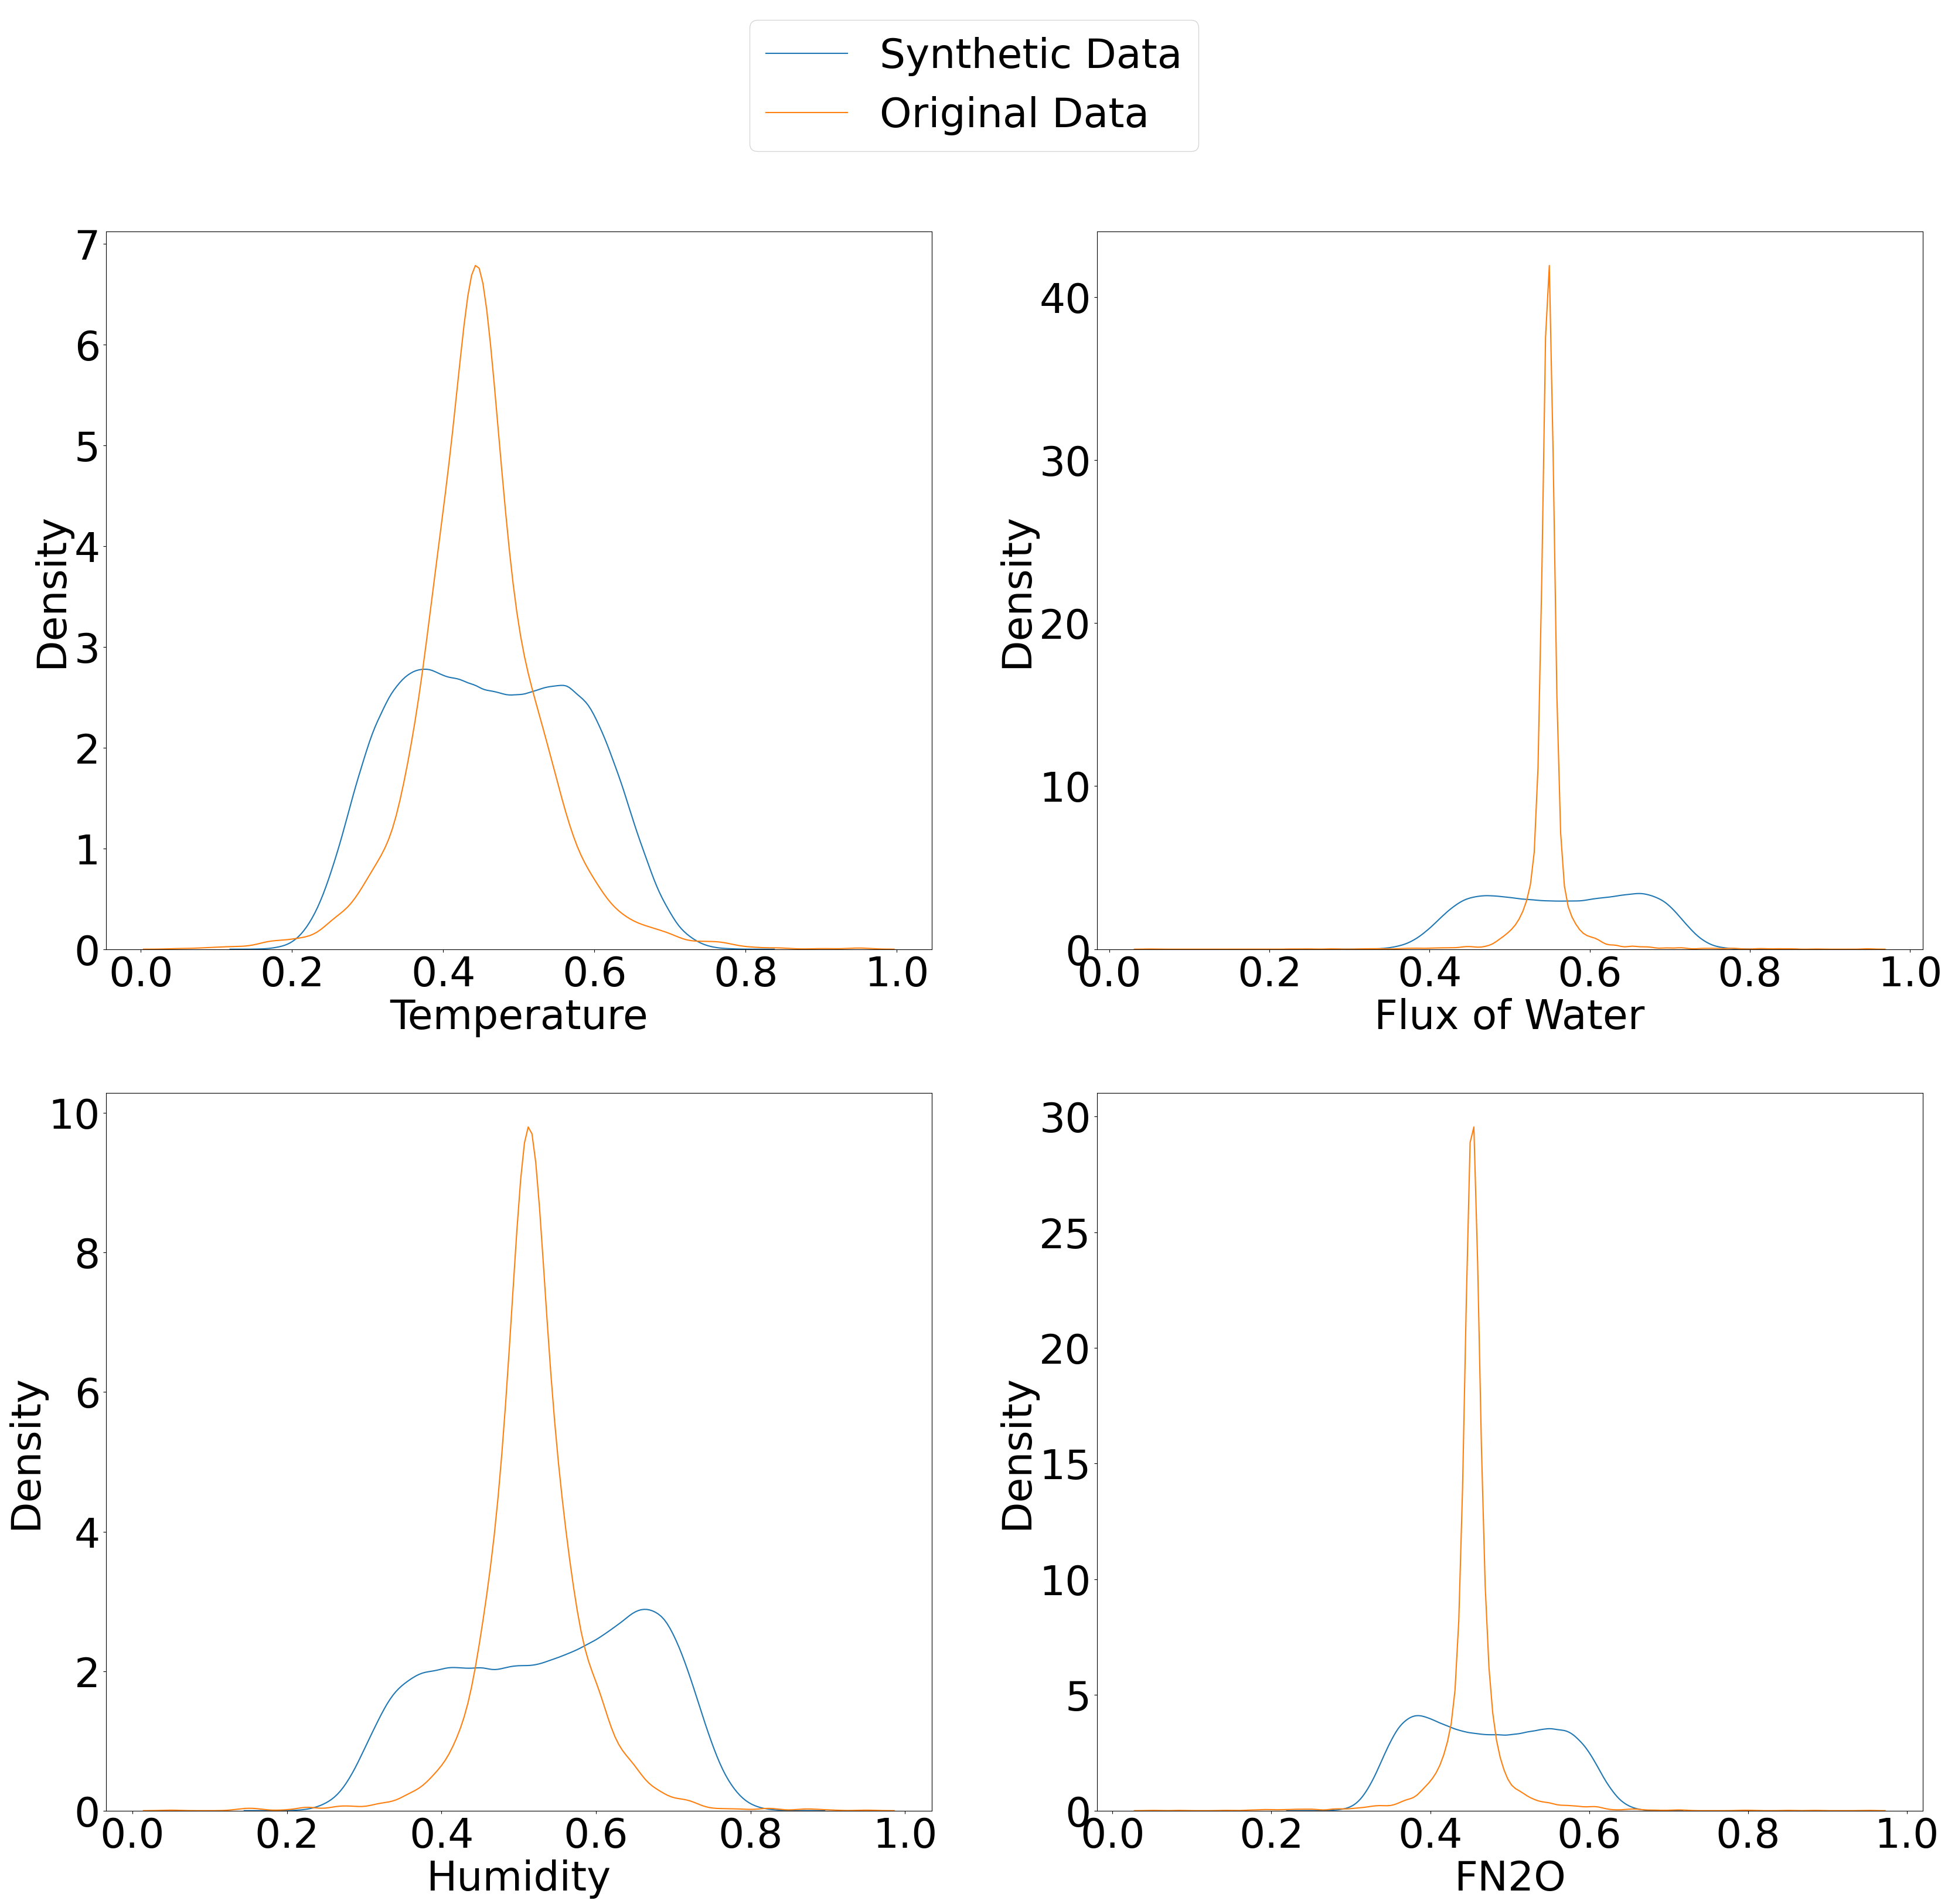

In [ ]:
width = 40
height = 35
plt.rcParams.update({'font.size': 50})

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(width, height))

labels = ["Synthetic Data", "Original Data"]

l1 = sns.kdeplot(order_data[:,1], ax=ax[0][0], label='Synthetic Data')
l2 = sns.kdeplot(scaled_data[:,1], ax=ax[0][0], label='Original Data')

ax[0][0].set_xlabel("Temperature")

sns.kdeplot(order_data[:,2], ax=ax[0][1])
sns.kdeplot(scaled_data[:,2], ax=ax[0][1])

ax[0][1].set_xlabel("Flux of Water")


sns.kdeplot(order_data[:,3], ax=ax[1][0])
sns.kdeplot(scaled_data[:,3], ax=ax[1][0])

ax[1][0].set_xlabel("Humidity")


sns.kdeplot(order_data[:,4], ax=ax[1][1])
sns.kdeplot(scaled_data[:,4], ax=ax[1][1])

ax[1][1].set_xlabel("FN2O")

f.legend([l1, l2], labels=labels,
           loc="upper center")

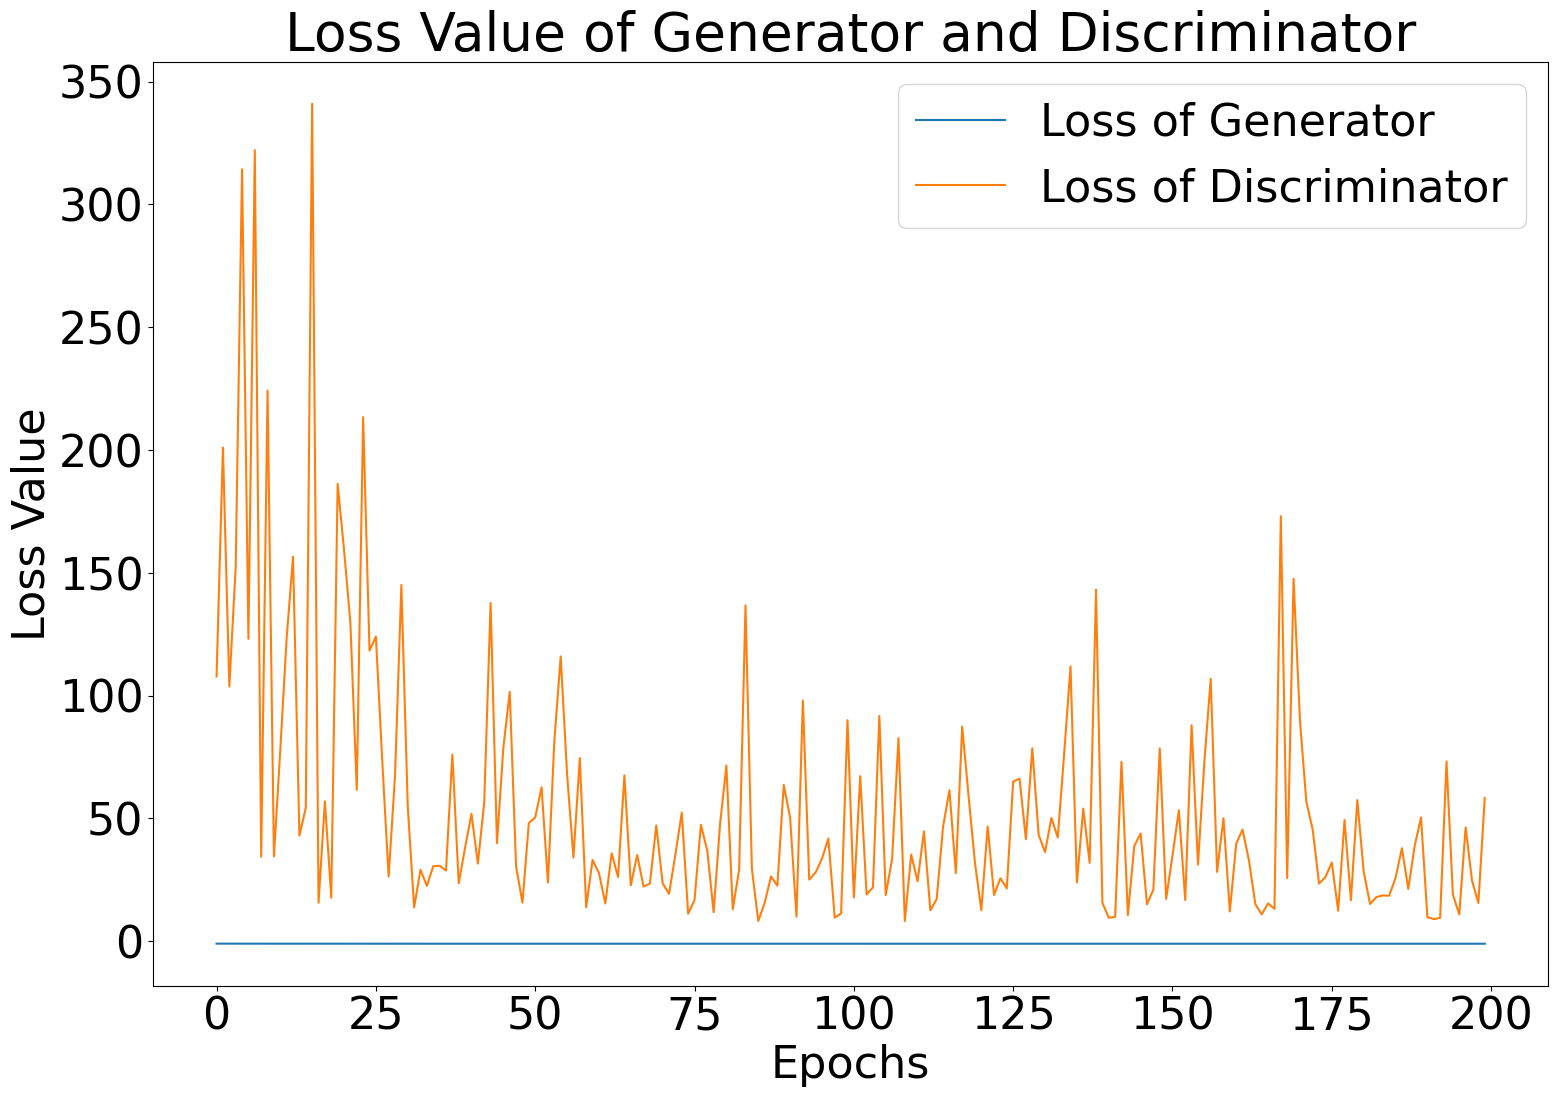

In [ ]:
# plot history
plt.rcParams.update({'font.size': 32})
plt.figure(figsize=(18, 12))
plt.plot(loss_G_lst, label='Loss of Generator')
plt.plot(loss_D_lst, label='Loss of Discriminator')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss Value of Generator and Discriminator")
plt.legend()
plt.show()

In the following section, the LSTM_DLEM will be tested using the augmented data and real data. In the data augmentation phrase, we need to select the data manually in order to choose the relatively better generated data.

In [ ]:
#noise = torch.randn(80000, 100, 1, 1).to(device)
augment_data = gen(torch.randn(60000, 100, 1, 1).to(device))

print(augment_data.shape)

torch.Size([60000, 1, 32, 6])


In [ ]:
augment_data = augment_data.reshape(1920000, 6)

In [ ]:
order_data = augment_data
order_data = order_data[order_data[:,0].argsort()]
order_data

tensor([[0.0333, 0.4444, 0.4813, 0.4128, 0.5504, 0.1858],
        [0.0338, 0.4413, 0.4827, 0.4127, 0.5406, 0.1838],
        [0.0344, 0.4407, 0.4704, 0.4413, 0.5444, 0.2217],
        ...,
        [0.9580, 0.1410, 0.1130, 0.3896, 0.0500, 0.4060],
        [0.9584, 0.1595, 0.1227, 0.4491, 0.0515, 0.4744],
        [0.9594, 0.1602, 0.1053, 0.4034, 0.0389, 0.4476]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [ ]:
order_data[:,1]

tensor([0.4581, 0.4963, 0.4420,  ..., 0.1824, 0.1345, 0.1559], device='cuda:0',
       grad_fn=<SelectBackward0>)